# Seminar 4. Text classification using CNN

Parameters of the task

In [2]:
# Task
max_words = 10000
max_len = 40
num_classes = 2

Let's download datasets
https://github.com/madrugado/keras-tutorial

In [3]:
import pandas as pd

base_url = "https://github.com/madrugado/keras-tutorial/raw/master/data"
# base_url = "./data"
df_train = pd.read_csv(f"{base_url}/train.csv")
df_test = pd.read_csv(f"{base_url}/test.csv")
df_val = pd.read_csv(f"{base_url}/val.csv")

We can look at some examples from training set

In [4]:
df_train

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1
...,...,...,...
181462,181462,Классным будет новый год..( http://t.co/LejaGu...,0
181463,181463,Видишь человека хочешь сказать ему привет . А ...,0
181464,181464,@Julia6_9Styles там длинный диагноз. Вкратце: ...,0
181465,181465,"@technoslav ух ты, а кому тот серенький кнопоч...",1


## Preprocessing

Let's create a corpus of the text

In [5]:
train_text = df_train["text"].str.lower()

and find all tokents

In [6]:
import nltk
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from tqdm.notebook import tqdm

nltk.download("punkt")


# tokens = train_text.apply(word_tokenize).sum()

tokens = []
for text in tqdm(train_text):
    tokens += word_tokenize(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  0%|          | 0/181467 [00:00<?, ?it/s]

Now filter ofnly numbers and words

In [7]:
tokens_filtered = [word for word in tokens if word.isalnum()]

Collect top N words in the corpus

In [8]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words - 1)]

Let's looks at them

In [9]:
print(tokens_filtered_top)

['не', 'я', 'и', 'в', 'rt', 'на', 'а', 'что', 'http', 'с', 'у', 'как', 'меня', 'это', 'так', 'мне', 'все', 'd', 'но', 'ты', 'ну', 'то', 'по', 'уже', 'за', 'вот', 'же', 'да', 'только', 'сегодня', 'еще', 'бы', 'нет', 'когда', 'хочу', 'тебя', 'очень', 'он', 'день', 'к', 'просто', 'мы', 'будет', 'от', 'было', 'тебе', 'если', 'из', 'теперь', 'надо', 'завтра', 'даже', 'тоже', 'до', 'там', 'о', 'его', 'есть', 'вообще', 'для', 'она', 'всё', 'сейчас', 'нас', 'спасибо', 'буду', 'кто', 'могу', 'блин', 'люблю', 'почему', 'без', 'вы', 'знаю', 'они', 'тут', 'или', 'раз', 'мой', 'ничего', 'больше', 'со', 'про', 'всегда', 'хорошо', 'можно', 'чем', 'всем', 'может', '2', 'дома', 'год', 'потом', 'ещё', 'был', 'спать', '3', 'такой', 'новый', 'время', 'их', 'чтобы', 'ни', 'опять', 'после', 'этот', 'делать', 'моя', 'где', 'была', 'пока', 'себя', 'быть', 'вас', 'всех', 'лучше', 'хоть', 'хочется', 'много', 'такое', 'себе', 'всего', 'один', 'этого', 'такая', 'такие', 'скоро', 'вам', 'нужно', 'вчера', 'настроен

Now we are building vocabulary to encode every token using index

In [10]:
import numpy as np
import pandas as pd

vocabulary = pd.Series(index=tokens_filtered_top, data=np.arange(1, max_words))
vocabulary

,0
не,1
я,2
и,3
в,4
rt,5
...,...
близкими,9995
марш,9996
рассказы,9997
падение,9998


In [12]:
def text_to_sequence(text, maxlen):
    # Convert vocabulary index to set for faster lookup
    vocab_set = set(vocabulary.index)

    # Tokenize and filter the tokens
    tokens = [
        word
        for word in word_tokenize(text.lower())
        if word.isalnum() and word in vocab_set
    ]

    # Convert tokens to indices
    result = [vocabulary[word] for word in tokens]

    # Pad the sequence with zeros or truncate to the maxlen
    padding = [0] * (maxlen - len(result))
    return result[-maxlen:] + padding


In [13]:
x_train = np.array(
    [text_to_sequence(text, max_len) for text in tqdm(df_train["text"])], dtype=np.int32
)
x_test = np.array(
    [text_to_sequence(text, max_len) for text in tqdm(df_test["text"])], dtype=np.int32
)
x_val = np.array(
    [text_to_sequence(text, max_len) for text in tqdm(df_val["text"])], dtype=np.int32
)

  0%|          | 0/181467 [00:00<?, ?it/s]

  0%|          | 0/22684 [00:00<?, ?it/s]

  0%|          | 0/22683 [00:00<?, ?it/s]

In [14]:
x_train.shape, x_test.shape, x_val.shape

((181467, 40), (22684, 40), (22683, 40))

In [15]:
type(x_train)

numpy.ndarray

In [16]:
print(*df_train["text"].head(), sep="\n")

@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.
RT @GalyginVadim: Ребята и девчата!
Все в кино!!! "Вот Это Любовь!"
Сегодня! Завтра!  И потом!)))))
#вотэтолюбовь
RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT
RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :)
@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......))


In [17]:
x_train[:5]

array([[   1,    2,   53,    1,   35,  102,   20,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   5,  599,    3,   17,    4,  527,   26,   14,  416,   30,   51,
           3,   93,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   5,   67, 1445, 1189,  835,    5,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   5,  118,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

Let's prepare class labels

In [18]:
y_train = np.array(df_train["class"])
y_val = np.array(df_val["class"])

In [19]:
y_train[:10]

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1])

In [20]:
y_train.shape

(181467,)

## Network

In [21]:
import torch
import torch.nn as nn

In [22]:
class Net(nn.Module):
    def __init__(
        self,
        vocab_size=max_words,
        embedding_dim=128,
        out_channel=256,
        num_classes=num_classes,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(
            embedding_dim,
            out_channel,
            kernel_size=3,
        )
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):  # [*, 40]
        # посл-сть индексов (вектор) -> посл-сть векторов (матрица)
        x = self.embedding(x)  # [*, 40, 128]
        # смена мест последних двух размерностей
        x = x.permute(0, 2, 1)  # [*, 128, 40]
        # применяем свёртку
        x = self.conv(x)  # [*, 256, 38]
        # накладываем нелинейность
        x = self.relu(x)  # [*, 256, 38]
        # берём максимум
        x = torch.max(x, dim=2).values  # [*, 256]
        # предсказываем
        x = self.linear(x)  # [*, 2]
        return x


## Training

In [23]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
            self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [24]:
batch_size = 256

In [25]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()


train_dataset = DataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

Net(
  (embedding): Embedding(10000, 128)
  (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=2, bias=True)
)
Parameters: 1379074
Device: cuda


In [ ]:
epochs = 10
print_batch_n = 100

In [32]:
for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        # compute output
        output = model(data)

        # compute gradient and do SGD step
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        if i % print_batch_n == 0:
            loss = loss.float().item()
            print(f"Step {i}: {loss=}")
            loss_history.append(loss)

Train epoch 1/10
Step 0: loss=0.014922035858035088
Step 100: loss=0.022126419469714165
Step 200: loss=0.013209163211286068
Step 300: loss=0.01406631339341402
Step 400: loss=0.019719842821359634
Step 500: loss=0.018643904477357864
Step 600: loss=0.014793644659221172
Step 700: loss=0.018397707492113113
Train epoch 2/10
Step 0: loss=0.0217105932533741
Step 100: loss=0.009589322842657566
Step 200: loss=0.016217852011322975
Step 300: loss=0.03323812037706375
Step 400: loss=0.017180291935801506
Step 500: loss=0.02973691187798977
Step 600: loss=0.025600599125027657
Step 700: loss=0.023061349987983704
Train epoch 3/10
Step 0: loss=0.011298563331365585
Step 100: loss=0.014730943366885185
Step 200: loss=0.028786109760403633
Step 300: loss=0.009319153614342213
Step 400: loss=0.02485310100018978
Step 500: loss=0.01209467463195324
Step 600: loss=0.01871701516211033
Step 700: loss=0.013798302970826626
Train epoch 4/10
Step 0: loss=0.010242771357297897
Step 100: loss=0.01833006553351879
Step 200: los

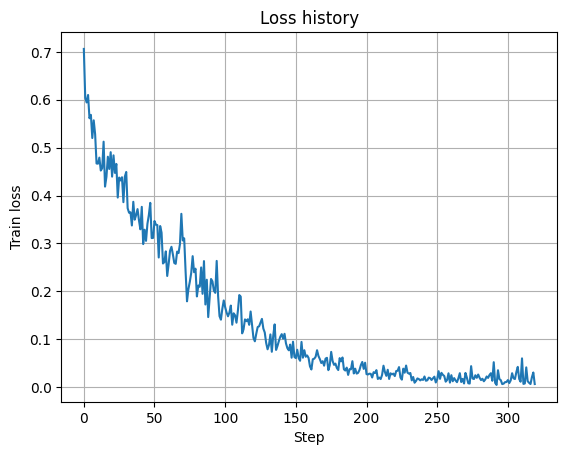

In [33]:
import matplotlib.pyplot as plt

plt.title("Loss history")
plt.grid(True)
plt.ylabel("Train loss")
plt.xlabel("Step")
plt.plot(loss_history)

In [34]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [35]:
model.eval()

pred = []
for i, (data, target) in enumerate(test_loader):
    data = data.to(device)
    # compute output
    output = model(data)
    output = torch.argmax(output, dim=1).detach().cpu()
    pred.extend(output.tolist())

In [36]:
pred[:10]

[1, 0, 0, 1, 1, 0, 1, 1, 1, 0]

In [37]:
df_test[:10]

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."
5,204155,в Питере какой то Сайлент Хилл) http://t.co/gB...
6,204156,@Brokerrr2 ухты какой молодец)) ахаха) а ты со...
7,204157,"Мальчишки-кадеты, осталось детство где-то.))\n..."
8,204158,RT @MrFarneo: Было жутко больно :-/ http://t.c...
9,204159,Ромка что то раздобрел и купилмне киндер) Стра...


## Using pre-trained word2vec

## gensim

In [38]:
import gensim.downloader as api

print(*api.info()["models"], sep="\n")

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [39]:
wv = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [40]:
vocab = pd.Series(wv.key_to_index) + 1
vocab

,0
the,1
",",2
.,3
of,4
to,5
...,...
chanty,399996
kronik,399997
rolonda,399998
zsombor,399999


In [41]:
wv.vectors.shape

(400000, 50)

In [42]:
wv_tensor = torch.from_numpy(wv.vectors)
wv_emb = torch.nn.Embedding.from_pretrained(
    wv_tensor,
)
wv_emb

Embedding(400000, 50)

## fasttext

In [ ]:
%pip install -q fasttext

Creating new embedding weights from pre-trained model:

In [ ]:
def load_pretrained_vectors(word2idx, model):
    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), model.get_dimension()))
    embeddings[word2idx["<pad>"]] = np.zeros((model.get_dimension(),))

    count = 0
    for word, index in word2idx.items():
        embeddings[index] = model.get_word_vector(word)
        count += 1

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

Loading pre-trained fasttext model

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz .

--2024-03-11 13:56:01--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz     12%[=>                  ] 556.19M  77.5MB/s    eta 56s    ^C


In [ ]:
!gunzip cc.ru.300.bin.gz

In [ ]:
import fasttext.util

# fasttext.util.download_model('ru', if_exists='ignore')  # Russian
ft = fasttext.load_model("cc.ru.300.bin")

ft.get_word_vector('не')

In [ ]:
ft.get_nearest_neighbors("тюмень")

[(0.832332193851471, 'екатеринбург'),
 (0.7883850932121277, 'иркутск'),
 (0.7748076915740967, 'челябинск'),
 (0.7735596299171448, 'тверь'),
 (0.7704686522483826, 'тюмени'),
 (0.7691737413406372, 'казань'),
 (0.7625898718833923, 'оренбург'),
 (0.761424720287323, 'воронеж'),
 (0.7604470252990723, 'ульяновск'),
 (0.7570189237594604, 'томск')]

In [ ]:
import numpy as np

vocabulary["<pad>"] = 0
embeddings = load_pretrained_vectors(vocabulary, ft)

There are 10000 / 10000 pretrained vectors found.


Initializing model embedding matrix:

In [ ]:
new_model = Net(vocab_size=max_words, embedding_dim=300)
new_model.embedding.weight.data.copy_(torch.tensor(embeddings))

tensor([[ 0.0114, -0.0257,  0.0245,  ..., -0.0323, -0.0474, -0.0325],
        [-0.0238,  0.0174, -0.0431,  ...,  0.1375, -0.1223, -0.2806],
        [ 0.0962, -0.0766, -0.0073,  ...,  0.0935, -0.4126, -0.1097],
        ...,
        [ 0.0281, -0.0593, -0.0590,  ..., -0.0229, -0.0192,  0.0152],
        [ 0.0427, -0.0328,  0.0313,  ...,  0.0106, -0.0517, -0.0375],
        [ 0.0274, -0.0345, -0.0449,  ..., -0.0400, -0.0066, -0.0266]])